In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import random
import math 
import pandas as pd

In [2]:
## Load in image folder.
data_directory = 'C:\\Users\\User\\Desktop\\leukemia capstone'
categories = ['BAS','EBO','EOS','KSC','LYA','LYT','MMZ','MOB','MON',
              'MYB','NGS','MYO','NGB','PMB','PMO']

In [3]:
img_folder = []
class_folder = [] 
def create_dataset(dataset):
     for label in dataset:
        path = os.path.join(data_directory,label)
        ##classification = categories.index(label)
        for image in os.listdir(path):
            try:
                image_array = cv2.imread(os.path.join(path,image),0)
                img_folder.append(image_array)
                class_folder.append(label)
            except Exception as e:
                print("Image was a problem {}".format(image))

In [4]:
create_dataset(categories)

In [15]:
data_label = zip(img_folder,class_folder)

In [21]:
from scipy import stats

def bin_pixels(image, centers):
    bins = [stats.norm.pdf(image, loc=c, scale=std) for c in centers]
    bins = np.stack(bins,axis=-1)
    bins /= bins.sum(axis=1)[:,np.newaxis]
    bins = bins.sum(axis=0)
    return bins

def make_bins(image_folder, df=None):
    """ Bin images according to gaussian distribution, one row per image 
        Append these to the dataframe or create one if none is passed
    """
    images = map(np.ravel,image_folder)
    images = np.vstack(images)
    if df is None:
        centers = np.array([35, 85, 125, 165, 205, 245])
    else:
        centers = df.columns.to_numpy()
    binned_images = np.apply_along_axis(bin_pixels, 1, images, centers)
    binned_images_df = pd.DataFrame(binned_images, columns=centers)
    df = binned_images_df if df is None else df.append(binned_images_df, ignore_index=True)
    return df


In [22]:
std=25
data_frame = pd.DataFrame(columns=[35, 85, 125, 165, 205, 245])

In [23]:
data_frame = make_bins(img_folder, data_frame)

<ipython-input-21-d3ec2210f6fd>:15: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  images = np.vstack(images)


In [24]:
data_frame.head()

,35,85,125,165,205,245
0,8712.721443,3279.095153,16609.232351,71357.832693,56542.240014,3498.878345
1,10747.458681,4015.895393,11889.039690,45974.309823,63587.564327,23785.732086
2,2777.049171,8282.663493,12155.791222,35649.788854,95532.832343,5601.874917
3,12192.918311,4948.432880,28852.074195,35786.930334,74423.850548,3795.793732
4,7643.250093,7024.395848,33038.923821,36694.977726,68038.729434,7559.723079


In [25]:
data_frame['class'] = class_folder

In [27]:
data_frame.to_csv('image_bins.csv')

In [28]:
# PCA analysis to see if generated features achieve better segmentaton between classes 
from sklearn.decomposition import PCA 
pca = PCA(n_components=2, random_state=100)
no_labels = data_frame.drop(columns=['class'])
bin_pca = pca.fit_transform(no_labels)


In [29]:
pca_df = pd.DataFrame(data=bin_pca, columns=['PCA1', 'PCA2'])
pca_df['class'] = data_frame['class']

In [30]:
pca_df.head()

,PCA1,PCA2,class
0,17072.048662,-20730.023931,BAS
1,13069.705136,9058.080655,BAS
2,-24720.553160,6370.179103,BAS
3,-6280.565591,-6580.694948,BAS
4,1457.725658,-7229.886525,BAS


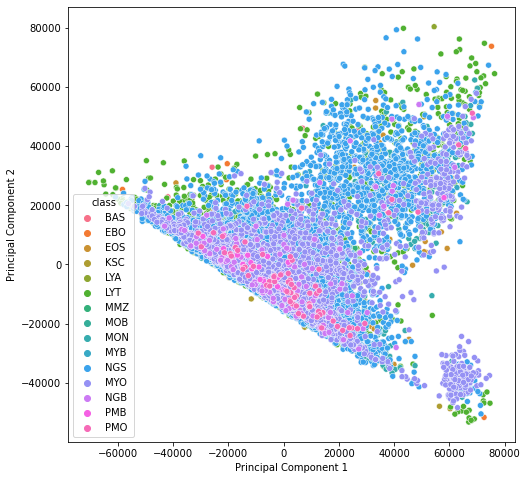

In [33]:
import seaborn as sns 
plt.figure(figsize=(8,8))
sns.scatterplot(data=pca_df,x='PCA1',y='PCA2',hue='class')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.savefig('PCA on full dataset.png')

In [35]:
data_frame.describe()

,35,85,125,165,205,245
count,18365.000000,18365.000000,18365.000000,18365.000000,18365.000000,18365.000000
mean,10040.674413,4686.097026,15955.266085,45399.171263,72659.329885,11259.461327
std,5302.683242,5464.961287,11631.953307,14065.574523,19869.801109,15762.801224
min,0.095179,294.607484,847.068403,7640.114046,0.000193,0.001176
25%,6216.600098,1728.242154,7281.509523,35386.297820,61467.142178,2092.805958
50%,9049.751165,2706.834118,12587.400428,45489.130882,73730.777966,5286.004645
75%,12808.017902,5463.814113,21849.507473,55158.832325,85885.762762,12253.551400
max,40022.745238,63113.806717,101537.576872,106826.982694,137144.847226,102669.441928


In [36]:
from sklearn.preprocessing import LabelEncoder
gle = LabelEncoder()
image_labels = gle.fit_transform(data_frame['class'])
label_mappings = { index:label for index, label in enumerate(gle.classes_) }
label_mappings

{0: 'BAS',
 1: 'EBO',
 2: 'EOS',
 3: 'KSC',
 4: 'LYA',
 5: 'LYT',
 6: 'MMZ',
 7: 'MOB',
 8: 'MON',
 9: 'MYB',
 10: 'MYO',
 11: 'NGB',
 12: 'NGS',
 13: 'PMB',
 14: 'PMO'}

In [38]:
data_frame['class'] = image
data_frame.head()

,35,85,125,165,205,245,class
0,8712.721443,3279.095153,16609.232351,71357.832693,56542.240014,3498.878345,0
1,10747.458681,4015.895393,11889.039690,45974.309823,63587.564327,23785.732086,0
2,2777.049171,8282.663493,12155.791222,35649.788854,95532.832343,5601.874917,0
3,12192.918311,4948.432880,28852.074195,35786.930334,74423.850548,3795.793732,0
4,7643.250093,7024.395848,33038.923821,36694.977726,68038.729434,7559.723079,0


In [39]:
data_frame['class'].value_counts()

12    8484
5     3937
10    3268
8     1789
2      424
11     109
0       79
1       78
14      70
9       42
7       26
13      18
6       15
3       15
4       11
Name: class, dtype: int64

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.model_selection import train_test_split
X = data_frame.drop(columns=['class'])
y = data_frame['class']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=50)
logistic_model = LogisticRegression(random_state=50, class_weight='balanced', solver='lbfgs', multi_class='multinomial', max_iter = 500)
logistic_model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=500,
                   multi_class='multinomial', random_state=50)

In [44]:
print(X_train.shape, y_train.shape)

(13773, 6) (13773,)


In [46]:
print(X_test.shape, y_test.shape)

(4592, 6) (4592,)


In [73]:
prediction_length = len(logistic_model.predict_proba(X_train))
prediction_certainty = np.array([ logistic_model.predict_proba(X_train)[x].max() for x in range(prediction_length)])

In [85]:
pred_bool = prediction_certainty > 0.5 
output = np.where(pred_bool)[0]
print('The logistic model predicts a class with greater than 50% certainty for {}, or {}% of the training set' 
      .format(len(output), round(100*(len(output)/prediction_length), 3)))

The logistic model predicts a class with greater than 50% certainty for 1218, or 8.843% of the training set


In [89]:
training_score = logistic_model.score(X_train, y_train)*100
print('The training set got a score of {} %'.format(round(training_score,3)))

The training set got a score of 36.768 %


In [ ]:
## apply SMOTE (Synthetic Minority Oversampling Technique) to balance imbalanced dataset


In [80]:
# set parameters for blob detection 
params = cv2.SimpleBlobDetector_Params()

# set area parameters for detcting blob size
params.filterByArea = True
params.minArea = 100

# set circularity paramaters for detecting circular blobs  
params.filterByCircularity = True
params.minCircularity = 0.8

# set convexity parameter
params.filterByConvexity = True
params.minConvexity = 0.3

# set inertia paramaeter 
params.filterByInertia = True 
params.minInertiaRatio = 0.02

In [48]:
## set directory path for images. 
path = os.path.join(data_directory,'BAS')
folder = os.listdir(path)
example = random.choice(folder)

example

'BAS_0010.tiff'